In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install opencv-python
!pip install cmake
!pip install dlib

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 사진준비

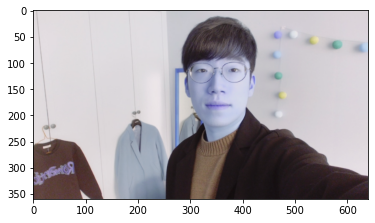

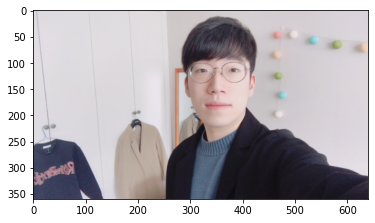

In [4]:
import os
my_image_path = '/content/drive/MyDrive/Github/AIFFEL/Exploration_3/camera_sticker/images/test.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출 face detection

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)#dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.
dlib_rects = detector_hog(img_rgb, 1)   #(image, num of img pyramid)이미지를 upsampling 방법을 통해 크기를 키우는 것
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.

rectangles[[(270, 64) (425, 219)]]


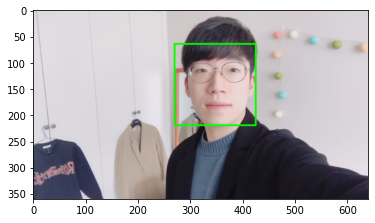

In [6]:
#찾은 얼굴을 화면에 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 얼굴 랜드마크 face landmark


이목구비의 위치를 추론하는 것을 face landmark localization 기술

face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [7]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat.bz2 ./drive/MyDrive/Github/AIFFEL/Exploration_3/camera_sticker/models
# !cd ~/content/drive/MyDrive/Github/AIFFEL/Exploration_3/camera_sticker/ && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [8]:
import os
model_path = '/content/drive/MyDrive/Github/AIFFEL/Exploration_3/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


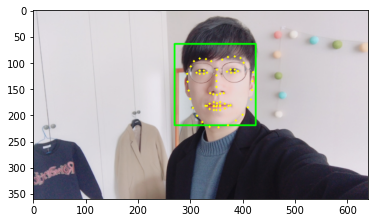

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(350, 146)
(x,y) : (350,68)
(w,h) : (156,156)


얼굴 이미지에서는 코의 중심점이 (350, 146)

In [12]:
import os
sticker_path = '/content/drive/MyDrive/Github/AIFFEL/Exploration_3/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


In [32]:
refined_x = x - w //2   # left
refined_y = y - h //2 +200  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,190)


In [33]:
#opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. 
#ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 
#따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.
#-y 크기만큼 스티커를 crop 합니다.
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (272,0)


In [34]:
# #이미지 짤리는값 허용
# sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
#     np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
# # sticker_area = img_show
# # img_show = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

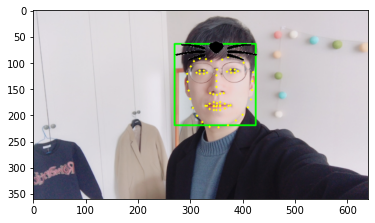

In [35]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

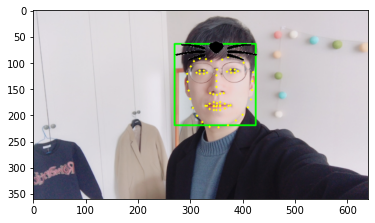

In [36]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 스티커 적용하기

In [37]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

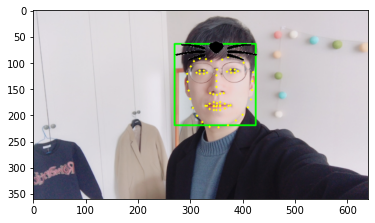

In [38]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()